## Model training for different experiments

This notebook covers the steps that we took in order to curate a model of satisfactory result. Each step follows an improvement in terms of adding more to the model or manipulating the training dataset in order to get more data for training or simply adding more images from an online source. 

The notebook starts off with a simple model and the training set given, after which, more complexity is added to the model denoted in the sections below

These are the sections in the notebook. 

1. [Import dependencies](#import-dependencies)
2. [Creating our first set of model](#creating-our-first-set-of-model) 
3. [Improving model by experiments](#improving-model-by-experiments)
4. [Second Model](#second-model): Added Dropout and other layers
5. [Third Model](#third-model): Removing Outliers
   1. [Third.1 model](#third1-model): Added images from [kaggle](https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification/)
6. [Fourth Model](#fourth-model): Image Augmentation on the fly
7. [Fifth model](#fifth-model): Saved augmented images
8. [Sixth Model](#sixth-model): More complexed model
   1. [Sixth.1 Model](#sixth1-model): Trained on augmented images
   2. [Sixth.2 Model](#sixth2-model): Trained on added images
9. [Collating all the accuracy results](#collating-all-the-accuracy-results)





## Import dependencies

In [1]:
# Importing dependencies
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

import pickle # For saving training history
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, re

from sklearn.metrics import f1_score

## Creating our first set of model

In [2]:
# Using google colab for training

# from google.colab import drive
# drive.mount("/content/drive")

Generating Dataset

In [58]:
# Defining Number of classes and image input size
num_classes = 4
image_height, image_width = (224,224)

In [59]:
# Generating Data sets with data generator
def generateTrainValidSets(datagen, filepath, googlecolab = True):
    trainDataSet = datagen.flow_from_directory(
        target_size=(image_height, image_width),
        directory=
        r"/content/drive/Othercomputers/New Desktop/NUS ISS/Sem 2/Machine Learning/09 Team Project/" if googlecolab ==True else "" + filepath,
        subset = "training",
        class_mode = "categorical",
        shuffle = True,
        batch_size = 8
    )

    validDataSet = datagen.flow_from_directory(
        target_size=(image_height, image_width),
        directory=r"/content/drive/Othercomputers/New Desktop/NUS ISS/Sem 2/Machine Learning/09 Team Project/" if googlecolab ==True else "" + filepath,
        subset = "validation",
        class_mode = "categorical",
        shuffle = True,
        batch_size = 8
    )

    # Preparing the test set data generator
    test_datagen = ImageDataGenerator(rescale=1./255)

    testDataSet = test_datagen.flow_from_directory(
        directory = r"/content/drive/Othercomputers/New Desktop/NUS ISS/Sem 2/Machine Learning/09 Team Project/" if googlecolab ==True else "" + "test_sorted",
        target_size=(image_height, image_width),
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )

    return trainDataSet, validDataSet, testDataSet

In [75]:
# Inputing images using ImageDataGenerator without augmentation to get baseline
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

trainDataSet, validDataSet, testDataSet= generateTrainValidSets(datagen, "train_sorted",False)

Found 193 images belonging to 4 classes.
Found 47 images belonging to 4 classes.
Found 60 images belonging to 4 classes.


In [162]:
firstmodel = Sequential()

firstmodel.add(Conv2D(64, (2, 2), activation='relu', padding='same', input_shape=(image_height, image_width, 3)))
firstmodel.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
firstmodel.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

# Flatten the nodes for the last layer
firstmodel.add(Flatten())
firstmodel.add(Dense(32, activation='relu'))
firstmodel.add(Dense(num_classes, activation='softmax'))

# Compile the model
firstmodel.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [166]:
num_epochs = 45
history = firstmodel.fit(
    trainDataSet,
    steps_per_epoch = trainDataSet.samples // trainDataSet.batch_size,
    epochs = num_epochs,
    validation_data = validDataSet,
    validation_steps = validDataSet.samples // validDataSet.batch_size,
    verbose = 1
)

Epoch 1/45
24/24 [==============================] - 2s 68ms/step - loss: 7.7522 - accuracy: 0.3405 - val_loss: 1.6420 - val_accuracy: 0.4000
Epoch 2/45
24/24 [==============================] - 2s 66ms/step - loss: 1.1146 - accuracy: 0.5351 - val_loss: 0.9570 - val_accuracy: 0.5500
Epoch 3/45
24/24 [==============================] - 2s 67ms/step - loss: 0.7854 - accuracy: 0.7027 - val_loss: 0.6391 - val_accuracy: 0.7000
Epoch 4/45
24/24 [==============================] - 2s 68ms/step - loss: 0.4384 - accuracy: 0.8216 - val_loss: 0.4105 - val_accuracy: 0.8000
Epoch 5/45
24/24 [==============================] - 2s 65ms/step - loss: 0.2528 - accuracy: 0.9081 - val_loss: 0.4936 - val_accuracy: 0.8250
Epoch 6/45
24/24 [==============================] - 2s 64ms/step - loss: 0.3459 - accuracy: 0.8649 - val_loss: 0.5655 - val_accuracy: 0.8250
Epoch 7/45
24/24 [==============================] - 2s 63ms/step - loss: 0.2001 - accuracy: 0.9243 - val_loss: 0.5106 - val_accuracy: 0.7500
Epoch 8/45
24

Saving the model and the history of the first model

In [154]:
# Saving the first model
firstmodel.save('first_model.keras')

In [ ]:
with open('/content/drive/Othercomputers/New Desktop/NUS ISS/Sem 2/Machine Learning/09 Team Project/first_model_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
import matplotlib.pyplot as plt

In [72]:
def plotTraining(history):
    # Extract loss and accuracy values for plotting.
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']  
    test_accuracy = history.history['val_accuracy']  

    # Set figure size and create two subplots.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # Width, Height

    # Plot training & test loss values.
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(test_loss, label='Testing Loss')
    ax1.set_title('Model loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')

    # Plot training & test accuracy values.
    ax2.plot(train_accuracy, label='Training Accuracy')
    ax2.plot(test_accuracy, label='Testing Accuracy')
    ax2.set_title('Model accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')

    # Show the plot
    plt.show()

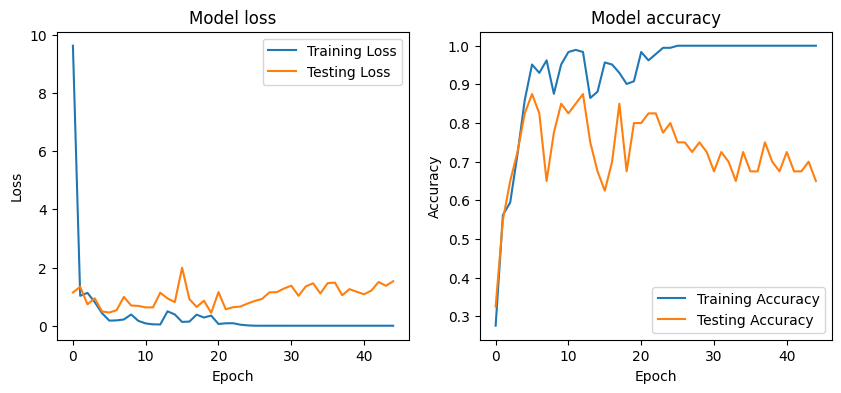

In [73]:
plotTraining(history)

We can observe that the training reached a steady state in around 10~20 epochs. We will try fitting again with a lower number of epoch at 15

In [211]:
firstmodel = tf.keras.models.load_model('first_model.keras')

In [124]:
def get_f1score(model,testDataSet):
    predictions = model.predict(testDataSet, steps=testDataSet.samples)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = testDataSet.classes
    return round(f1_score(true_classes,predicted_classes, average='macro'),3)

In [151]:
firstmodel_f1score = get_f1score(firstmodel,testDataSet)

60/60 [==============================] - 1s 11ms/step


In [153]:
firstmodel_trainscore = firstmodel.evaluate(trainDataSet,steps=trainDataSet.samples // trainDataSet.batch_size)
firstmodel_validationscore = firstmodel.evaluate(validDataSet,steps=validDataSet.samples // validDataSet.batch_size)
firstmodel_testscore = firstmodel.evaluate(testDataSet,steps=testDataSet.samples // testDataSet.batch_size)

60/60 [==============================] - 1s 9ms/step - loss: 3.7268 - accuracy: 0.7000


In [158]:
print("The base model accuracy score for the train: ",round(firstmodel_trainscore[1],2))
print("The base model accuracy score for the validation: ",round(firstmodel_validationscore[1],2))
print("======================================================")
print("The base model accuracy score for the test: ",round(firstmodel_testscore[1],2))

The base model accuracy score for the train:  0.99
The base model accuracy score for the validation:  0.75
The base model accuracy score for the test:  0.7


As observed from evaluating the accuracy score across the 3 datasets, we notice that the model is overfitted, having a **0.7** score for the test set while having near to **1.00** for the training set.

The model does really badly for the test set as the model has overfitted to the training set and not generalised. This could also be where the number of epoch is **too high**, therefore causing the model to overfit

In [163]:
# Trying first model with a lower epoch
num_epochs = 15
history = firstmodel.fit(
    trainDataSet,
    steps_per_epoch = trainDataSet.samples // trainDataSet.batch_size,
    epochs = num_epochs,
    validation_data = validDataSet,
    validation_steps = validDataSet.samples // validDataSet.batch_size,
    verbose = 1
)

Epoch 1/15
24/24 [==============================] - 2s 70ms/step - loss: 7.4464 - accuracy: 0.3568 - val_loss: 0.8795 - val_accuracy: 0.6750
Epoch 2/15
24/24 [==============================] - 2s 67ms/step - loss: 1.1460 - accuracy: 0.5622 - val_loss: 1.1237 - val_accuracy: 0.5750
Epoch 3/15
24/24 [==============================] - 2s 64ms/step - loss: 1.1759 - accuracy: 0.6649 - val_loss: 0.9442 - val_accuracy: 0.6500
Epoch 4/15
24/24 [==============================] - 2s 68ms/step - loss: 0.9934 - accuracy: 0.6865 - val_loss: 1.0018 - val_accuracy: 0.5750
Epoch 5/15
24/24 [==============================] - 2s 64ms/step - loss: 0.6685 - accuracy: 0.7297 - val_loss: 0.7865 - val_accuracy: 0.5750
Epoch 6/15
24/24 [==============================] - 2s 67ms/step - loss: 0.6949 - accuracy: 0.7568 - val_loss: 0.8095 - val_accuracy: 0.6250
Epoch 7/15
24/24 [==============================] - 2s 62ms/step - loss: 0.9789 - accuracy: 0.6595 - val_loss: 1.3668 - val_accuracy: 0.3750
Epoch 8/15
24

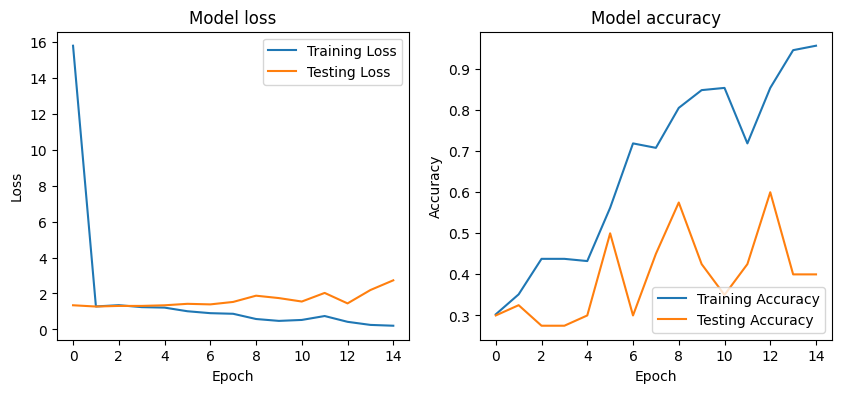

In [78]:
plotTraining(history)

In [164]:
firstmodel_trainscore = firstmodel.evaluate(trainDataSet,steps=trainDataSet.samples // trainDataSet.batch_size)
firstmodel_validationscore = firstmodel.evaluate(validDataSet,steps=validDataSet.samples // validDataSet.batch_size)
firstmodel_testscore = firstmodel.evaluate(testDataSet,steps=testDataSet.samples // testDataSet.batch_size)

60/60 [==============================] - 1s 10ms/step - loss: 1.9890 - accuracy: 0.5333


In [165]:
print("The base model accuracy score for the train: ",round(firstmodel_trainscore[1],2))
print("The base model accuracy score for the validation: ",round(firstmodel_validationscore[1],2))
print("======================================================")
print("The base model accuracy score for the test: ",round(firstmodel_testscore[1],2))

The base model accuracy score for the train:  0.96
The base model accuracy score for the validation:  0.62
The base model accuracy score for the test:  0.53


Seems like with lower epoch, the difference is very vast and undesirable. We will stick to a higher number of epoch at around 40 to 60 range and could possibly lower learning rate in the later models.

## Improving model by experiments 

### Second Model 
Adding dropouts, maxpooling and regularisation

In [237]:
secondmodel = Sequential()

secondmodel.add(Conv2D(64, (2, 2), activation='relu', padding='same', input_shape=(image_height, image_width, 3)))
secondmodel.add(Dropout(0.25))
secondmodel.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
secondmodel.add(Dropout(0.25))
secondmodel.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
secondmodel.add(MaxPooling2D(pool_size=(2, 2), strides=2))
secondmodel.add(Dropout(0.15))
secondmodel.add(Flatten())
secondmodel.add(Dense(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
secondmodel.add(Dropout(0.25))

secondmodel.add(Dense(num_classes, activation='softmax'))

# Compile the model
secondmodel.compile(optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [134]:
num_epochs = 75
history = secondmodel.fit(
    trainDataSet,
    steps_per_epoch = trainDataSet.samples // trainDataSet.batch_size,
    epochs = num_epochs,
    validation_data = validDataSet,
    validation_steps = validDataSet.samples // validDataSet.batch_size,
    verbose = 1
)

Epoch 1/75
24/24 [==============================] - 2s 67ms/step - loss: 7.7153 - accuracy: 0.2973 - val_loss: 3.3522 - val_accuracy: 0.3250
Epoch 2/75
24/24 [==============================] - 2s 68ms/step - loss: 3.1479 - accuracy: 0.2865 - val_loss: 2.8924 - val_accuracy: 0.3250
Epoch 3/75
24/24 [==============================] - 2s 67ms/step - loss: 2.5964 - accuracy: 0.3351 - val_loss: 2.4100 - val_accuracy: 0.3000
Epoch 4/75
24/24 [==============================] - 2s 67ms/step - loss: 2.2085 - accuracy: 0.3784 - val_loss: 2.0690 - val_accuracy: 0.3000
Epoch 5/75
24/24 [==============================] - 2s 67ms/step - loss: 1.8172 - accuracy: 0.4541 - val_loss: 1.6456 - val_accuracy: 0.5000
Epoch 6/75
24/24 [==============================] - 2s 67ms/step - loss: 1.5432 - accuracy: 0.5405 - val_loss: 1.5245 - val_accuracy: 0.6250
Epoch 7/75
24/24 [==============================] - 2s 68ms/step - loss: 1.4991 - accuracy: 0.5946 - val_loss: 1.3447 - val_accuracy: 0.7500
Epoch 8/75
24

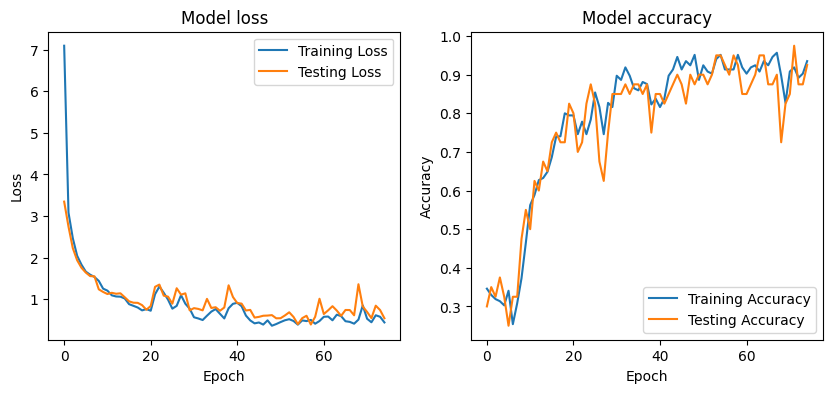

In [138]:
plotTraining(history)

The training loss curves looks good as compared to the first model where you see 

#### Saving the second model

In [138]:
# Saving the second model
#secondmodel.save('second_model.keras')

In [215]:
secondmodel = tf.keras.models.load_model('second_model.keras')

In [146]:
secondmodel_trainscore = secondmodel.evaluate(trainDataSet,steps=trainDataSet.samples // trainDataSet.batch_size)
secondmodel_validationscore = secondmodel.evaluate(validDataSet,steps=validDataSet.samples // validDataSet.batch_size)
secondmodel_testscore = secondmodel.evaluate(testDataSet,steps=testDataSet.samples // testDataSet.batch_size)

60/60 [==============================] - 1s 8ms/step - loss: 0.6919 - accuracy: 0.8667


In [147]:
secondmodel_f1score = get_f1score(secondmodel,testDataSet)

60/60 [==============================] - 1s 8ms/step


In [ ]:
print("The base model accuracy score for the train: ",secondmodel_trainscore[1])
print("The base model accuracy score for the validation: ",round(secondmodel_validationscore[1],2))
print("======================================================")
print("The base model accuracy score for the test: ",round(secondmodel_testscore[1],2))


The base model accuracy score for the train:  0.984375
The base model accuracy score for the validation:  0.93
The base model accuracy score for the test:  0.87


We achieved a 0.04 improvement in the accuracy. Next we will remove the outliers to check for any improvements

### Third Model
Removing outliers

In [166]:
# Training path
train_path = "train_sorted"

# Excluding outliers
UmapwrongImageList = ["train_sorted/banana/banana_61.jpg","train_sorted/apple/apple_3.jpg"]
wrongImageList = ["train_sorted/banana/banana_35.jpg","train_sorted/banana/banana_61.jpg","train_sorted/mixed/mixed_20.jpg"]
outliers = wrongImageList + UmapwrongImageList

def generateCleanDF(train_path,outliers):
# Creating a dataframe to facilitate the flow_from_dataframe function for the ImageDataGenerator
    imagedata = []
    row = 0
    for classname in os.listdir(train_path):
        classpath = os.path.join(train_path, classname)
        for imagepath in os.listdir(classpath):
            imagerelativepath = os.path.join(classname,imagepath)
            if ("train_sorted/" + classname + "/" + imagepath) not in outliers:
                imagedata.append([imagerelativepath, classname])


    imagedataframe = pd.DataFrame(data= imagedata, columns=("pathname","class"))
    return imagedataframe

imagedataframe = generateCleanDF(train_path,outliers)

In [167]:
imagedataframe.shape

(236, 2)

In [224]:
# Generating dataset using flow_from_dataframe and removing outliers identited earlier
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

cleaned_train_generator = datagen.flow_from_dataframe(
    dataframe=imagedataframe,
    directory=train_path,
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='training',
    class_mode='categorical',
    shuffle=True,
    batch_size=8
)

cleaned_validation_generator = datagen.flow_from_dataframe(
    dataframe=imagedataframe,
    directory=train_path,
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='validation',
    class_mode='categorical',
    shuffle=True,
    batch_size=8
)

Found 189 validated image filenames belonging to 4 classes.
Found 47 validated image filenames belonging to 4 classes.


In [ ]:
num_epochs = 75
history = secondmodel.fit(
    cleaned_train_generator,
    steps_per_epoch = cleaned_train_generator.samples // cleaned_train_generator.batch_size,
    epochs = num_epochs,
    validation_data = cleaned_validation_generator,
    validation_steps = cleaned_validation_generator.samples // cleaned_validation_generator.batch_size,
    verbose = 1
)

Epoch 1/75
17/23 [=====================>........] - ETA: 18s - loss: 7.1603 - accuracy: 0.3015

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


23/23 [==============================] - 101s 4s/step - loss: 6.2023 - accuracy: 0.2818 - val_loss: 3.3335 - val_accuracy: 0.0000e+00
Epoch 2/75
23/23 [==============================] - 3s 109ms/step - loss: 3.0428 - accuracy: 0.3812 - val_loss: 2.9360 - val_accuracy: 0.0000e+00
Epoch 3/75
23/23 [==============================] - 3s 117ms/step - loss: 2.4268 - accuracy: 0.3536 - val_loss: 2.3570 - val_accuracy: 0.6750
Epoch 4/75
23/23 [==============================] - 3s 126ms/step - loss: 2.0184 - accuracy: 0.5359 - val_loss: 2.2010 - val_accuracy: 0.0000e+00
Epoch 5/75
23/23 [==============================] - 4s 168ms/step - loss: 1.6853 - accuracy: 0.5635 - val_loss: 2.0278 - val_accuracy: 0.2500
Epoch 6/75
23/23 [==============================] - 3s 128ms/step - loss: 1.6004 - accuracy: 0.5746 - val_loss: 2.0957 - val_accuracy: 0.0250
Epoch 7/75
23/23 [==============================] - 3s 116ms/step - loss: 1.4349 - accuracy: 0.5580 - val_loss: 1.8121 - val_accuracy: 0.0000e+00
Ep

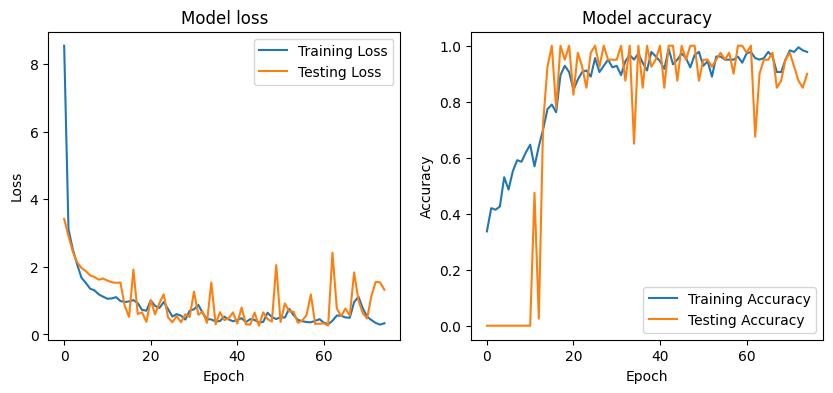

In [179]:
plotTraining(history)

In [ ]:
# Saving the third model
#secondmodel.save('third_model.keras')

In [221]:
thirdmodel = tf.keras.models.load_model('third_model.keras')

In [186]:
thirdmodel_trainscore = thirdmodel.evaluate(cleaned_train_generator,steps=cleaned_train_generator.samples // cleaned_train_generator.batch_size)
thirdmodel_validationscore = thirdmodel.evaluate(cleaned_validation_generator,steps=cleaned_validation_generator.samples // cleaned_validation_generator.batch_size)
thirdmodel_testscore = thirdmodel.evaluate(testDataSet,steps=testDataSet.samples // testDataSet.batch_size)

19/23 [=======================>......] - ETA: 0s - loss: 0.9972 - accuracy: 0.9868

c:\Users\calvi\anaconda3\envs\tensorflowgpu\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


60/60 [==============================] - 0s 8ms/step - loss: 1.2952 - accuracy: 0.9167


In [184]:
thirdmodel_f1score = get_f1score(thirdmodel,testDataSet)

60/60 [==============================] - 1s 8ms/step


In [183]:
print("The base model accuracy score for the train: ",round(thirdmodel_trainscore[1],2))
print("The base model accuracy score for the validation: ",round(thirdmodel_validationscore[1],2))
print("======================================================")
print("The base model accuracy score for the test: ",round(thirdmodel_testscore[1],2))


The base model accuracy score for the train:  0.98
The base model accuracy score for the validation:  0.98
The base model accuracy score for the test:  0.92


We see another round of improvement on the test set by 0.05. This means that by removing the outlier, the model can now better classify the images

### Third.1 model
In this experiment, we will add more training data from [kaggle](https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification/) containing images for orange, apple and banana. This data set includes fresh and rotten image, which we will only add the images of the fresh fruits.

In [21]:
# Getting the files in the train dataset
filepaths = os.listdir('train_sorted (added images)')

imagecount = {"apple": 0,"banana": 0,"orange": 0, "mixed": 0}
for classpath in filepaths:
  num_images = os.listdir("train_sorted (added images)/" + classpath)
  imagecount[classpath] = len(num_images)

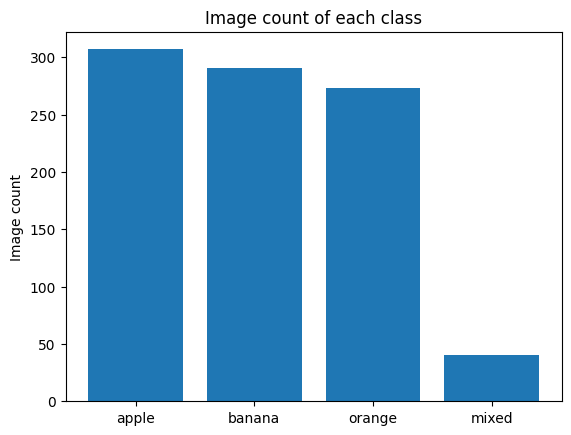

In [22]:
plt.bar(imagecount.keys(),imagecount.values())
plt.ylabel("Image count")
plt.title("Image count of each class")
plt.show()

In [190]:
train_path = "train_sorted (added images)"
cleanAdditionalDF = generateCleanDF(train_path,outliers)

In [191]:
# Generating dataset using flow_from_dataframe and removing outliers identited earlier
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

cleaned_train_generator = datagen.flow_from_dataframe(
    dataframe=cleanAdditionalDF,
    directory=train_path,
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='training',
    class_mode='categorical',
    shuffle=True,
    batch_size=8
)

cleaned_validation_generator = datagen.flow_from_dataframe(
    dataframe=cleanAdditionalDF,
    directory=train_path,
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='validation',
    class_mode='categorical',
    shuffle=True,
    batch_size=8
)

Found 726 validated image filenames belonging to 4 classes.
Found 181 validated image filenames belonging to 4 classes.


In [91]:
num_epochs = 30
history = secondmodel.fit(
    cleaned_train_generator,
    steps_per_epoch = cleaned_train_generator.samples // cleaned_train_generator.batch_size,
    epochs = num_epochs,
    validation_data = cleaned_validation_generator,
    validation_steps = cleaned_validation_generator.samples // cleaned_validation_generator.batch_size,
    verbose = 1
)

Epoch 1/30
89/90 [============================>.] - ETA: 0s - loss: 3.9824 - accuracy: 0.4507

c:\Users\calvi\anaconda3\envs\tensorflowgpu\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


90/90 [==============================] - 5s 44ms/step - loss: 3.9543 - accuracy: 0.4526 - val_loss: 2.1613 - val_accuracy: 0.0000e+00
Epoch 2/30
90/90 [==============================] - 4s 42ms/step - loss: 1.3765 - accuracy: 0.6045 - val_loss: 1.5434 - val_accuracy: 0.0000e+00
Epoch 3/30
90/90 [==============================] - 4s 42ms/step - loss: 1.1812 - accuracy: 0.5919 - val_loss: 1.4235 - val_accuracy: 0.0000e+00
Epoch 4/30
90/90 [==============================] - 4s 42ms/step - loss: 1.0584 - accuracy: 0.6170 - val_loss: 1.3830 - val_accuracy: 0.0000e+00
Epoch 5/30
90/90 [==============================] - 4s 41ms/step - loss: 1.0111 - accuracy: 0.6184 - val_loss: 1.2538 - val_accuracy: 0.0000e+00
Epoch 6/30
90/90 [==============================] - 4s 42ms/step - loss: 1.0675 - accuracy: 0.6462 - val_loss: 1.4827 - val_accuracy: 0.0000e+00
Epoch 7/30
90/90 [==============================] - 4s 41ms/step - loss: 1.0220 - accuracy: 0.6616 - val_loss: 1.4338 - val_accuracy: 0.0000e

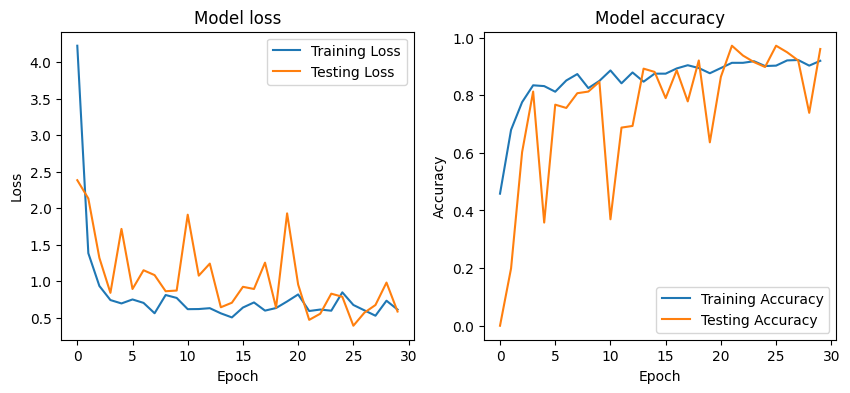

In [193]:
plotTraining(history)

In [95]:
# Saving the third model
# secondmodel.save('third.1_model.keras')

In [195]:
third1model = tf.keras.models.load_model('third.1_model.keras')

In [202]:
thirdmodel1_trainscore = third1model.evaluate(cleaned_train_generator,steps=cleaned_train_generator.samples // cleaned_train_generator.batch_size)
thirdmodel1_validationscore = third1model.evaluate(cleaned_validation_generator,steps=cleaned_validation_generator.samples // cleaned_validation_generator.batch_size)
thirdmodel1_testscore = third1model.evaluate(testDataSet,steps=testDataSet.samples // testDataSet.batch_size)

60/60 [==============================] - 1s 8ms/step - loss: 0.6102 - accuracy: 0.8667


In [205]:
third1model_f1score = get_f1score(third1model,testDataSet)

60/60 [==============================] - 1s 10ms/step


In [203]:
print("The base model accuracy score for the train: ",round(thirdmodel1_trainscore[1],2))
print("The base model accuracy score for the validation: ",round(thirdmodel1_validationscore[1],2))
print("======================================================")
print("The base model accuracy score for the test: ",round(thirdmodel1_testscore[1],2))


The base model accuracy score for the train:  0.96
The base model accuracy score for the validation:  0.96
The base model accuracy score for the test:  0.87


It seems like the model did not perform any better when fed with more data. Ultimately, there could be some reasons for this.

1) Overfit with too much data, model not picking up the important features to focus on
2) Test data set might be too small in order to see any significant improvements

### Fourth Model
For the fourth model, we are augmenting the images on the fly and feeding it to the model for training. This step does not save the images directly to a folder.
Generating more images from the datasets allows the model to be more robust, learning more the features that are more 'important'.

In [238]:
# Excluding outliers
outliers = wrongImageList + UmapwrongImageList

train_path = "train_sorted (added images)"
cleanAdditionalDF = generateCleanDF(train_path,outliers)

In [239]:
# Defining our augmentation parameters
augmenteddatagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [240]:
# Generating augmented images (without the outliers) on the fly 
augmented_train_generator = augmenteddatagen.flow_from_dataframe(
    dataframe=cleanAdditionalDF,
    directory=train_path,
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='training',
    class_mode='categorical',
    shuffle=True,
    batch_size=16
)

augmented_validation_generator = augmenteddatagen.flow_from_dataframe(
    dataframe=cleanAdditionalDF,
    directory=train_path,
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='validation',
    class_mode='categorical',
    shuffle=True,
    batch_size=16
)


Found 726 validated image filenames belonging to 4 classes.


Found 181 validated image filenames belonging to 4 classes.


In [32]:
num_epochs = 40
with tf.device('/GPU:0'):
    history = secondmodel.fit(
        augmented_train_generator,
        steps_per_epoch = augmented_train_generator.samples // augmented_train_generator.batch_size,
        epochs = num_epochs,
        validation_data = augmented_validation_generator,
        validation_steps = augmented_validation_generator.samples // augmented_validation_generator.batch_size,
        verbose = 1
    )

Epoch 1/40
45/45 [==============================] - ETA: 0s - loss: 0.8871 - accuracy: 0.7490

C:\Users\calvi\anaconda3\envs\tensorflowgpu\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


45/45 [==============================] - 8s 166ms/step - loss: 0.8871 - accuracy: 0.7490 - val_loss: 1.4797 - val_accuracy: 0.0511
Epoch 2/40
45/45 [==============================] - 8s 169ms/step - loss: 0.8351 - accuracy: 0.7755 - val_loss: 1.3128 - val_accuracy: 0.3920
Epoch 3/40
45/45 [==============================] - 8s 181ms/step - loss: 0.8719 - accuracy: 0.7713 - val_loss: 0.7787 - val_accuracy: 0.8182
Epoch 4/40
45/45 [==============================] - 8s 169ms/step - loss: 0.7491 - accuracy: 0.8201 - val_loss: 0.8744 - val_accuracy: 0.6648
Epoch 5/40
45/45 [==============================] - 8s 169ms/step - loss: 0.7380 - accuracy: 0.8368 - val_loss: 0.8447 - val_accuracy: 0.8352
Epoch 6/40
45/45 [==============================] - 7s 165ms/step - loss: 0.7094 - accuracy: 0.8382 - val_loss: 0.7959 - val_accuracy: 0.8182
Epoch 7/40
45/45 [==============================] - 8s 169ms/step - loss: 0.7096 - accuracy: 0.8438 - val_loss: 0.8711 - val_accuracy: 0.9261
Epoch 8/40
45/45 

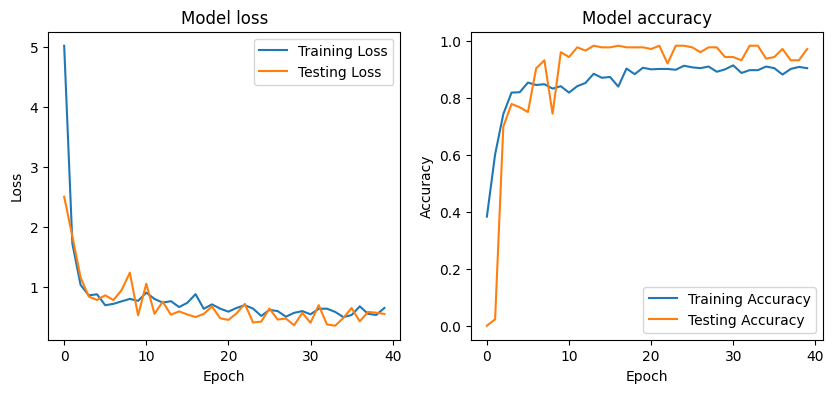

In [242]:
plotTraining(history)

In [36]:
# Saving the third model
# secondmodel.save('fourth_model.keras')

In [231]:
fourthmodel = tf.keras.models.load_model('fourth_model.keras')

In [33]:
fourthmodel_trainscore = secondmodel.evaluate(augmented_train_generator,steps=augmented_train_generator.samples // augmented_train_generator.batch_size)
fourthmodel_validationscore = secondmodel.evaluate(augmented_validation_generator,steps=augmented_validation_generator.samples // augmented_validation_generator.batch_size)
fourthmodel_testscore = secondmodel.evaluate(testDataSet,steps=testDataSet.samples // testDataSet.batch_size)

60/60 [==============================] - 1s 9ms/step - loss: 0.8405 - accuracy: 0.8667


In [250]:
fourthmodel_f1score = get_f1score(fourthmodel,testDataSet)

60/60 [==============================] - 1s 10ms/step


In [236]:
print("The base model accuracy score for the train: ",round(fourthmodel_trainscore[1],2))
print("The base model accuracy score for the validation: ",round(fourthmodel_validationscore[1],2))
print("======================================================")
print("The base model accuracy score for the test: ",round(fourthmodel_testscore[1],2))


The base model accuracy score for the train:  0.92
The base model accuracy score for the validation:  0.97
The base model accuracy score for the test:  0.87


From the score that we have obtained above, we are still seeing overfitting on the training set as compared to the validation and test set. We are going to attempt to improve the model with batch normalisation and increasing the nodes on the layers.


### Fifth model

For the next model, we will save the augmented image data set and check for the performance of the model

In [128]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Defining our augmentation parameters
augmenteddatagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

trainingpath = "train_sorted (augmented)"
classes = os.listdir(trainingpath)

num_images_per_class = {
    'apple': 5,
    'banana': 5,
    'orange': 5,
    'mixed': 15 
}

def augment_images(class_name, num_augmented_images):
    class_dir = os.path.join(trainingpath, class_name)
    for file in os.listdir(class_dir):
        if file.endswith(('.png', '.jpg', '.jpeg')):  
            file_path = os.path.join(class_dir, file)
            img = load_img(file_path)
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)

            # Generate and save the augmented images
            i = 0
            for batch in augmenteddatagen.flow(img_array, batch_size=1, save_to_dir=class_dir, save_prefix=class_name, save_format='jpeg'):
                i += 1
                if i >= num_augmented_images:
                    break  # Break after generating the required number of images

In [129]:
# Loop through the classes and augment images
for class_name in classes:
    print(f'Augmenting images for class: {class_name}')
    augment_images(class_name, num_images_per_class[class_name])

Augmenting images for class: apple


c:\Users\calvi\anaconda3\envs\tensorflowgpu\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Augmenting images for class: banana
Augmenting images for class: mixed
Augmenting images for class: orange


In [23]:
filepaths = os.listdir("train_sorted (augmented)")

imagecount = {"apple": 0,"banana": 0,"orange": 0, "mixed": 0}
for classpath in filepaths:
  num_images = os.listdir("train_sorted (augmented)/" + classpath)
  imagecount[classpath] = len(num_images)

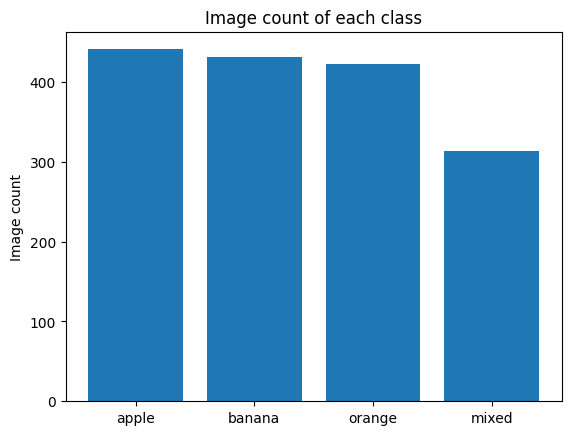

In [25]:
plt.bar(imagecount.keys(),imagecount.values())
plt.ylabel("Image count")
plt.title("Image count of each class")
plt.show()

Using the newly augmented dataset

In [245]:
# Inputing images using ImageDataGenerator 
datagen = ImageDataGenerator(
    validation_split=0.2
)

trainDataSet, validDataSet, testDataSet= generateTrainValidSets(datagen, "train_sorted (augmented)",False)

Found 1289 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 60 images belonging to 4 classes.


In [246]:
# Adding batch normalisation to further reduce overfitting
fifthmodel = Sequential()

fifthmodel.add(Conv2D(32, (2, 2), activation='relu', padding='same', input_shape=(image_height, image_width, 3)))
fifthmodel.add(BatchNormalization())
fifthmodel.add(MaxPooling2D(pool_size=(2, 2), strides=2))
fifthmodel.add(Dropout(0.15))
fifthmodel.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
fifthmodel.add(BatchNormalization())
fifthmodel.add(MaxPooling2D(pool_size=(2, 2), strides=2))
fifthmodel.add(Dropout(0.15))
fifthmodel.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
fifthmodel.add(BatchNormalization())
fifthmodel.add(MaxPooling2D(pool_size=(2, 2), strides=2))
fifthmodel.add(Dropout(0.15))


fifthmodel.add(Flatten())

# FC layer
fifthmodel.add(Dense(64, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
fifthmodel.add(Dropout(0.25))

fifthmodel.add(Dense(num_classes, activation='softmax'))

# Compile the model
fifthmodel.compile(optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [24]:
num_epochs = 50
with tf.device('/GPU:0'):
    history = fifthmodel.fit(
        trainDataSet,
        steps_per_epoch = trainDataSet.samples // trainDataSet.batch_size,
        epochs = num_epochs,
        validation_data = validDataSet,
        validation_steps = validDataSet.samples // validDataSet.batch_size,
        verbose = 1
    )

Epoch 1/50
161/161 [==============================] - 9s 53ms/step - loss: 6.6962 - accuracy: 0.5558 - val_loss: 3.8007 - val_accuracy: 0.6844
Epoch 2/50
161/161 [==============================] - 8s 52ms/step - loss: 3.6218 - accuracy: 0.5870 - val_loss: 3.0017 - val_accuracy: 0.5469
Epoch 3/50
161/161 [==============================] - 8s 52ms/step - loss: 2.7566 - accuracy: 0.5933 - val_loss: 2.2371 - val_accuracy: 0.6500
Epoch 4/50
161/161 [==============================] - 8s 51ms/step - loss: 3.2372 - accuracy: 0.4934 - val_loss: 3.2419 - val_accuracy: 0.6219
Epoch 5/50
161/161 [==============================] - 8s 52ms/step - loss: 2.9869 - accuracy: 0.5340 - val_loss: 2.4095 - val_accuracy: 0.6094
Epoch 6/50
161/161 [==============================] - 8s 52ms/step - loss: 2.3706 - accuracy: 0.6136 - val_loss: 2.8308 - val_accuracy: 0.5312
Epoch 7/50
161/161 [==============================] - 8s 52ms/step - loss: 2.1352 - accuracy: 0.6027 - val_loss: 1.9935 - val_accuracy: 0.5844

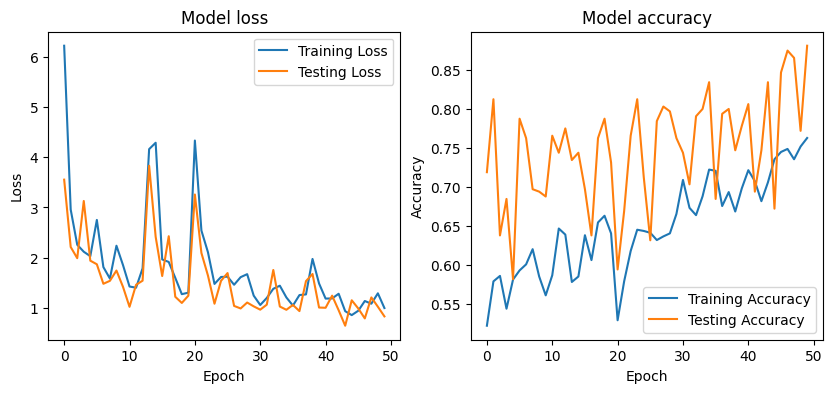

In [248]:
plotTraining(history)

In [25]:
# Saving the third model
fifthmodel.save('fifth_model.keras')

In [254]:
fifthmodel = tf.keras.models.load_model('fifth_model.keras')

In [87]:
fifthmodel_trainscore = fifthmodel.evaluate(trainDataSet,steps=trainDataSet.samples // trainDataSet.batch_size)
fifthmodel_validationscore = fifthmodel.evaluate(validDataSet,steps=validDataSet.samples // validDataSet.batch_size)
fifthmodel_testscore = fifthmodel.evaluate(testDataSet,steps=testDataSet.samples // testDataSet.batch_size)

60/60 [==============================] - 1s 9ms/step - loss: 4.1871 - accuracy: 0.3000


In [258]:
fifthmodel_f1score = get_f1score(fifthmodel,testDataSet)

60/60 [==============================] - 1s 11ms/step


In [94]:
print("The base model accuracy score for the train: ",round(fifthmodel_trainscore[1],2))
print("The base model accuracy score for the validation: ",round(fifthmodel_validationscore[1],2))
print("======================================================")
print("The base model accuracy score for the test: ",round(fifthmodel_testscore[1],2))

The base model accuracy score for the train:  0.88
The base model accuracy score for the validation:  0.86
The base model accuracy score for the test:  0.3


As we can see, the model is doing really badly on test set after saving the augmented images. We attempt to check what are the images that the model is not predicting correct for error analysis

In [33]:
def generatePredictionDF(test_generator,model):
    classpredictions = model.predict(test_generator,steps = test_generator.samples // test_generator.batch_size)
    predicted_classes = classpredictions.argmax(axis=1)
    true_classes = test_generator.classes
    checkprediction = predicted_classes == true_classes

    #Generate Pandas Dataframe 
    df = pd.DataFrame({"filepaths": test_generator.filepaths, "trueclass": true_classes,"predicted": predicted_classes ,"Correctly Predicted": checkprediction})
    return df

In [50]:
predictions = generatePredictionDF(testDataSet,fifthmodel)

 1/60 [..............................] - ETA: 1s

60/60 [==============================] - 0s 8ms/step


In [51]:
trainDataSet.class_indices

{'apple': 0, 'banana': 1, 'mixed': 2, 'orange': 3}

In [52]:
correctly_predicted = predictions[["trueclass","Correctly Predicted"]].groupby(by="trueclass").sum()
correctly_predicted["total count"] = predictions["trueclass"].value_counts()
correctly_predicted

,Correctly Predicted,total count
trueclass,,
0,0,19
1,18,18
2,0,5
3,0,18


We can observe that only the banana class is only predicted correctly. This is puzzling as visual inspection of the training data set seems quite similar to the test data set. It seems it might have overfitted to a certain class and did not generalised to the whole dataset.

### Sixth Model

We will try to improve the model by increasing the dropout rates and also introduct more CNN layers. We will also reduce the learning rate to make the model make more refined adjustments

In [299]:
# Adding batch normalisation to further reduce overfitting
sixthmodel = Sequential()

sixthmodel.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_height, image_width, 3))) # Increased the kernel size of filter 
sixthmodel.add(BatchNormalization())
sixthmodel.add(MaxPooling2D(pool_size=(2, 2)))
sixthmodel.add(Dropout(0.2)) # Increased Dropout 

sixthmodel.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # Increased the kernel size of filter
sixthmodel.add(BatchNormalization())
sixthmodel.add(MaxPooling2D(pool_size=(2, 2)))
sixthmodel.add(Dropout(0.3)) # Increased Dropout 

sixthmodel.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
sixthmodel.add(BatchNormalization())
sixthmodel.add(MaxPooling2D(pool_size=(2, 2)))
sixthmodel.add(Dropout(0.4)) # Increased Dropout 


sixthmodel.add(Flatten())

# FC layer
sixthmodel.add(Dense(128, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))  # Increased the number of neurons
sixthmodel.add(Dropout(0.5))

sixthmodel.add(Dense(num_classes, activation='softmax'))

# Compile the model
sixthmodel.compile(optimizer=Adam(learning_rate=0.0001), # Lowering the learning rate
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [262]:
train_path = "train_sorted (added images)"
cleanAdditionalDF = generateCleanDF(train_path,outliers)

In [263]:
# Generating dataset using flow_from_dataframe and removing outliers identited earlier
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

cleaned_train_generator = datagen.flow_from_dataframe(
    dataframe=cleanAdditionalDF,
    directory=train_path,
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='training',
    class_mode='categorical',
    shuffle=True,
    batch_size=8
)

cleaned_validation_generator = datagen.flow_from_dataframe(
    dataframe=cleanAdditionalDF,
    directory=train_path,
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='validation',
    class_mode='categorical',
    shuffle=True,
    batch_size=8
)

Found 726 validated image filenames belonging to 4 classes.


Found 181 validated image filenames belonging to 4 classes.


In [100]:
num_epochs = 30
with tf.device('/GPU:0'):
    history = sixthmodel.fit(
        cleaned_train_generator,
        steps_per_epoch = cleaned_train_generator.samples // cleaned_train_generator.batch_size,
        epochs = num_epochs,
        validation_data = cleaned_validation_generator,
        validation_steps = cleaned_validation_generator.samples // cleaned_validation_generator.batch_size,
        verbose = 1
    )

Epoch 1/30
88/90 [============================>.] - ETA: 0s - loss: 4.8118 - accuracy: 0.6809

c:\Users\calvi\anaconda3\envs\tensorflowgpu\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


90/90 [==============================] - 5s 44ms/step - loss: 4.7583 - accuracy: 0.6866 - val_loss: 16.5456 - val_accuracy: 0.0000e+00
Epoch 2/30
90/90 [==============================] - 4s 41ms/step - loss: 2.8405 - accuracy: 0.8259 - val_loss: 9.3360 - val_accuracy: 0.0000e+00
Epoch 3/30
90/90 [==============================] - 4s 41ms/step - loss: 2.5470 - accuracy: 0.8607 - val_loss: 4.0743 - val_accuracy: 0.6136
Epoch 4/30
90/90 [==============================] - 4s 41ms/step - loss: 2.3822 - accuracy: 0.8579 - val_loss: 3.2010 - val_accuracy: 0.7784
Epoch 5/30
90/90 [==============================] - 4s 41ms/step - loss: 2.2527 - accuracy: 0.8677 - val_loss: 3.7882 - val_accuracy: 0.7500
Epoch 6/30
90/90 [==============================] - 4s 40ms/step - loss: 2.1461 - accuracy: 0.8774 - val_loss: 2.6080 - val_accuracy: 0.8466
Epoch 7/30
90/90 [==============================] - 4s 40ms/step - loss: 2.0761 - accuracy: 0.8747 - val_loss: 2.4386 - val_accuracy: 0.8636
Epoch 8/30
90/9

In [264]:
num_epochs = 30
with tf.device('/GPU:0'):
    history = sixthmodel.fit(
        cleaned_train_generator,
        steps_per_epoch = cleaned_train_generator.samples // cleaned_train_generator.batch_size,
        epochs = num_epochs,
        validation_data = cleaned_validation_generator,
        validation_steps = cleaned_validation_generator.samples // cleaned_validation_generator.batch_size,
        verbose = 1
    )

Epoch 1/30
90/90 [==============================] - ETA: 0s - loss: 4.4602 - accuracy: 0.7006

c:\Users\calvi\anaconda3\envs\tensorflowgpu\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


90/90 [==============================] - 4s 42ms/step - loss: 4.4602 - accuracy: 0.7006 - val_loss: 13.0007 - val_accuracy: 0.0000e+00
Epoch 2/30
90/90 [==============================] - 3s 39ms/step - loss: 2.7185 - accuracy: 0.8524 - val_loss: 16.4586 - val_accuracy: 0.0000e+00
Epoch 3/30
90/90 [==============================] - 3s 38ms/step - loss: 2.5880 - accuracy: 0.8412 - val_loss: 7.4073 - val_accuracy: 0.2784
Epoch 4/30
90/90 [==============================] - 3s 38ms/step - loss: 2.4225 - accuracy: 0.8538 - val_loss: 5.3051 - val_accuracy: 0.5568
Epoch 5/30
90/90 [==============================] - 3s 38ms/step - loss: 2.3272 - accuracy: 0.8496 - val_loss: 5.6839 - val_accuracy: 0.5795
Epoch 6/30
90/90 [==============================] - 3s 38ms/step - loss: 2.1039 - accuracy: 0.8788 - val_loss: 2.6000 - val_accuracy: 0.8750
Epoch 7/30
90/90 [==============================] - 4s 39ms/step - loss: 2.0380 - accuracy: 0.8621 - val_loss: 2.4580 - val_accuracy: 0.8864
Epoch 8/30
90/

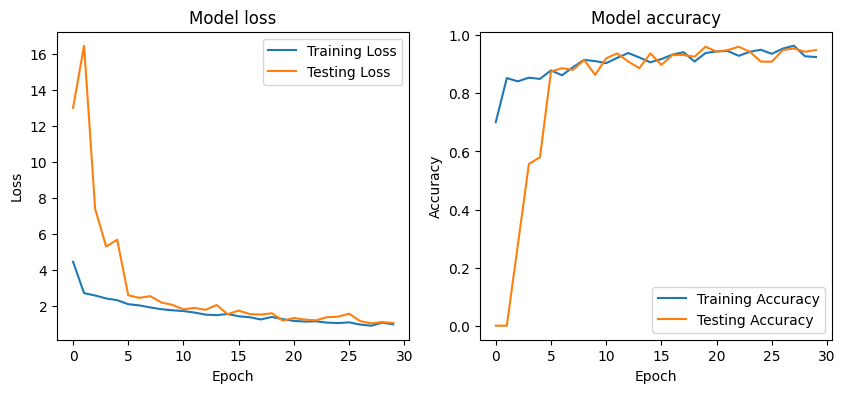

In [266]:
plotTraining(history)

In [104]:
# Saving the third model
sixthmodel.save('sixth_model.keras')

In [268]:
sixthmodel = tf.keras.models.load_model('sixth_model.keras')

In [269]:
trainDataSet, validDataSet, testDataSet= generateTrainValidSets(datagen, "train_sorted",False)

Found 193 images belonging to 4 classes.
Found 47 images belonging to 4 classes.
Found 60 images belonging to 4 classes.


In [271]:
sixthmodel_trainscore = sixthmodel.evaluate(cleaned_train_generator,steps=cleaned_train_generator.samples // cleaned_train_generator.batch_size)
sixthmodel_validationscore = sixthmodel.evaluate(cleaned_validation_generator,steps=cleaned_validation_generator.samples // cleaned_validation_generator.batch_size)
sixthmodel_testscore = sixthmodel.evaluate(testDataSet,steps=testDataSet.samples // testDataSet.batch_size)

60/60 [==============================] - 1s 8ms/step - loss: 2.5628 - accuracy: 0.8833


In [267]:
sixthmodel_f1score = get_f1score(sixthmodel,testDataSet)

60/60 [==============================] - 1s 10ms/step


In [272]:
print("The base model accuracy score for the train: ",round(sixthmodel_trainscore[1],2))
print("The base model accuracy score for the validation: ",round(sixthmodel_validationscore[1],2))
print("======================================================")
print("The base model accuracy score for the test: ",round(sixthmodel_testscore[1],2))

The base model accuracy score for the train:  0.98
The base model accuracy score for the validation:  0.97
The base model accuracy score for the test:  0.88


### Sixth.1 Model
Here we train with the augmented dataset

In [1]:
train_sort_path = "train_sorted (augmented images)"

In [276]:
# Excluding outliers
outliers = wrongImageList + UmapwrongImageList

# Creating a dataframe to facilitate the flow_from_dataframe function for the ImageDataGenerator
imagedata = []
row = 0
for classname in os.listdir(train_sort_path):
    classpath = os.path.join(train_sort_path, classname)
    for imagepath in os.listdir(classpath):
        imagerelativepath = os.path.join(classname,imagepath)
        if ("train_sorted/" + imagerelativepath) not in outliers:
            imagedata.append([imagerelativepath, classname])


imagedataframe = pd.DataFrame(data= imagedata, columns=("pathname","class"))

In [277]:
train_path = "train_sorted (added images)"
cleanAdditionalDF = generateCleanDF(train_path,outliers)

In [282]:
# Generating dataset using flow_from_dataframe and removing outliers identited earlier
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

cleaned_train_generator = datagen.flow_from_dataframe(
    dataframe=cleanAdditionalDF,
    directory=train_path,
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='training',
    class_mode='categorical',
    shuffle=True,
    batch_size=8
)

cleaned_validation_generator = datagen.flow_from_dataframe(
    dataframe=cleanAdditionalDF,
    directory=train_path,
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='validation',
    class_mode='categorical',
    shuffle=True,
    batch_size=8
)

Found 726 validated image filenames belonging to 4 classes.


Found 181 validated image filenames belonging to 4 classes.


In [126]:
num_epochs = 30
with tf.device('/GPU:0'):
    history = sixthmodel.fit(
        augmented_train_generator,
        steps_per_epoch = augmented_train_generator.samples // augmented_train_generator.batch_size,
        epochs = num_epochs,
        validation_data = augmented_validation_generator,
        validation_steps = augmented_validation_generator.samples // augmented_validation_generator.batch_size,
        verbose = 1
    )

Epoch 1/30
45/45 [==============================] - ETA: 0s - loss: 4.6824 - accuracy: 0.6227

c:\Users\calvi\anaconda3\envs\tensorflowgpu\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


45/45 [==============================] - 9s 184ms/step - loss: 4.6824 - accuracy: 0.6227 - val_loss: 6.4079 - val_accuracy: 0.0000e+00
Epoch 2/30
45/45 [==============================] - 8s 177ms/step - loss: 3.1401 - accuracy: 0.7167 - val_loss: 7.6113 - val_accuracy: 0.0000e+00
Epoch 3/30
45/45 [==============================] - 8s 178ms/step - loss: 2.9487 - accuracy: 0.7546 - val_loss: 6.1031 - val_accuracy: 0.0000e+00
Epoch 4/30
45/45 [==============================] - 8s 176ms/step - loss: 2.8364 - accuracy: 0.7447 - val_loss: 4.6850 - val_accuracy: 0.1989
Epoch 5/30
45/45 [==============================] - 8s 176ms/step - loss: 2.7484 - accuracy: 0.7826 - val_loss: 7.5624 - val_accuracy: 0.0227
Epoch 6/30
45/45 [==============================] - 8s 176ms/step - loss: 2.5926 - accuracy: 0.7980 - val_loss: 4.7417 - val_accuracy: 0.4034
Epoch 7/30
45/45 [==============================] - 8s 178ms/step - loss: 2.5461 - accuracy: 0.7924 - val_loss: 3.8618 - val_accuracy: 0.6477
Epoch

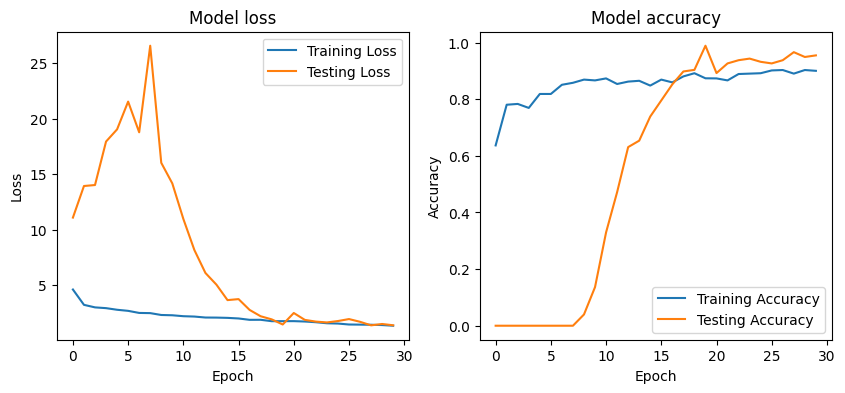

In [284]:
plotTraining(history)

In [130]:
# Saving the third model
sixthmodel.save('sixth.1_model.keras')

It seems adding data augmentation does not work too well for the model. We will instead try to balance the weights for model training to "pay more attention" to the unbalanced class which is the mixed class

In [285]:
sixthmodel1 = tf.keras.models.load_model('sixth.1_model.keras')

In [289]:
sixth1model_trainscore = sixthmodel1.evaluate(augmented_train_generator,steps=augmented_train_generator.samples // augmented_train_generator.batch_size)
sixth1model_validationscore = sixthmodel1.evaluate(augmented_validation_generator,steps=augmented_validation_generator.samples // augmented_validation_generator.batch_size)
sixth1model_testscore = sixthmodel1.evaluate(testDataSet,steps=testDataSet.samples // testDataSet.batch_size)

60/60 [==============================] - 1s 9ms/step - loss: 3.0263 - accuracy: 0.7500


In [290]:
sixth1model_f1score = get_f1score(sixthmodel1,testDataSet)

 1/60 [..............................] - ETA: 1s

60/60 [==============================] - 1s 9ms/step


In [128]:
print("The base model accuracy score for the train: ",round(sixthmodel_trainscore[1],2))
print("The base model accuracy score for the validation: ",round(sixthmodel_validationscore[1],2))
print("======================================================")
print("The base model accuracy score for the test: ",round(sixthmodel_testscore[1],2))

The base model accuracy score for the train:  0.75
The base model accuracy score for the validation:  0.91
The base model accuracy score for the test:  0.75


### Sixth.2 Model
Experimenting with adding weights to the model fitting while keeping everything the same

In [293]:
train_sort_path = "train_sorted (added images)"

In [294]:
# Excluding outliers
outliers = wrongImageList + UmapwrongImageList

# Creating a dataframe to facilitate the flow_from_dataframe function for the ImageDataGenerator
imagedata = []
row = 0
for classname in os.listdir(train_sort_path):
    classpath = os.path.join(train_sort_path, classname)
    for imagepath in os.listdir(classpath):
        imagerelativepath = os.path.join(classname,imagepath)
        if ("train_sorted/" + imagerelativepath) not in outliers:
            imagedata.append([imagerelativepath, classname])


imagedataframe = pd.DataFrame(data= imagedata, columns=("pathname","class"))

In [295]:
# Generating dataset using flow_from_dataframe and removing outliers identited earlier
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

cleaned_train_generator = datagen.flow_from_dataframe(
    dataframe=cleanAdditionalDF,
    directory=train_path,
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='training',
    class_mode='categorical',
    shuffle=True,
    batch_size=8
)

cleaned_validation_generator = datagen.flow_from_dataframe(
    dataframe=cleanAdditionalDF,
    directory=train_path,
    x_col='pathname',
    y_col='class',
    target_size=(image_height, image_width),
    subset='validation',
    class_mode='categorical',
    shuffle=True,
    batch_size=8
)

Found 726 validated image filenames belonging to 4 classes.


Found 181 validated image filenames belonging to 4 classes.


In [296]:
y_train_labels = cleaned_train_generator.labels
y_train_unique = np.unique(cleaned_train_generator.labels)

In [297]:
import sklearn
from sklearn.utils import class_weight

In [298]:
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = y_train_unique, 
    y = y_train_labels
)

class_weights_dict = dict(enumerate(class_weights))

In [57]:
num_epochs = 30
with tf.device('/GPU:0'):
    history = sixthmodel.fit(
        cleaned_train_generator,
        steps_per_epoch = cleaned_train_generator.samples // cleaned_train_generator.batch_size,
        epochs = num_epochs,
        validation_data = cleaned_validation_generator,
        validation_steps = cleaned_validation_generator.samples // cleaned_validation_generator.batch_size,
        class_weight = class_weights_dict,
        verbose = 1
    )

Epoch 1/30
90/90 [==============================] - 4s 41ms/step - loss: 5.3079 - accuracy: 0.6630 - val_loss: 25.1968 - val_accuracy: 0.0000e+00
Epoch 2/30
90/90 [==============================] - 4s 39ms/step - loss: 3.2102 - accuracy: 0.7145 - val_loss: 30.2597 - val_accuracy: 0.0000e+00
Epoch 3/30
90/90 [==============================] - 4s 39ms/step - loss: 2.8878 - accuracy: 0.7632 - val_loss: 24.9696 - val_accuracy: 0.0000e+00
Epoch 4/30
90/90 [==============================] - 3s 39ms/step - loss: 2.5590 - accuracy: 0.7994 - val_loss: 16.1234 - val_accuracy: 0.0000e+00
Epoch 5/30
90/90 [==============================] - 4s 39ms/step - loss: 2.4306 - accuracy: 0.7841 - val_loss: 4.5453 - val_accuracy: 0.5966
Epoch 6/30
90/90 [==============================] - 4s 39ms/step - loss: 2.3624 - accuracy: 0.7688 - val_loss: 3.3072 - val_accuracy: 0.7386
Epoch 7/30
90/90 [==============================] - 4s 39ms/step - loss: 2.2782 - accuracy: 0.7883 - val_loss: 1.8787 - val_accuracy: 

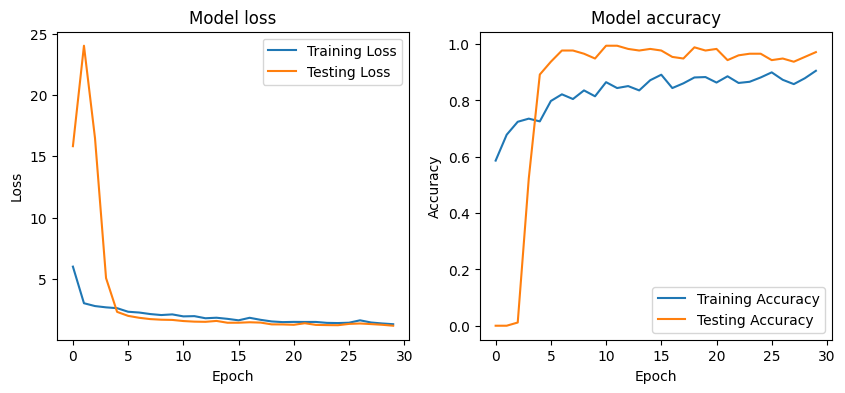

In [301]:
plotTraining(history)

In [17]:
trainDataSet, validDataSet, testDataSet= generateTrainValidSets(datagen, "train_sorted",False)

Found 193 images belonging to 4 classes.
Found 47 images belonging to 4 classes.
Found 60 images belonging to 4 classes.


In [63]:
# Saving the third model
sixthmodel.save('sixth.2_model.keras')

In [302]:
sixth2model = tf.keras.models.load_model('sixth.2_model.keras')

In [303]:
sixth2model_trainscore = sixth2model.evaluate(cleaned_train_generator,steps=cleaned_train_generator.samples // cleaned_train_generator.batch_size)
sixth2model_validationscore = sixth2model.evaluate(cleaned_validation_generator,steps=cleaned_validation_generator.samples // cleaned_validation_generator.batch_size)
sixth2model_testscore = sixth2model.evaluate(testDataSet,steps=testDataSet.samples // testDataSet.batch_size)

60/60 [==============================] - 1s 8ms/step - loss: 2.4368 - accuracy: 0.8500


In [305]:
sixth2model_f1score = get_f1score(sixth2model,testDataSet)

60/60 [==============================] - 1s 11ms/step


In [304]:
print("The base model accuracy score for the train: ",round(sixth2model_trainscore[1],2))
print("The base model accuracy score for the validation: ",round(sixth2model_validationscore[1],2))
print("======================================================")
print("The base model accuracy score for the test: ",round(sixth2model_testscore[1],2))

The base model accuracy score for the train:  0.98
The base model accuracy score for the validation:  0.94
The base model accuracy score for the test:  0.85


In [34]:
predictions = generatePredictionDF(testDataSet,sixth2model)

 1/60 [..............................] - ETA: 1s

60/60 [==============================] - 1s 10ms/step


In [38]:
predictions.head()

,filepaths,trueclass,predicted,Correctly Predicted
0,test_sorted\apple\apple_77.jpg,0,0,True
1,test_sorted\apple\apple_78.jpg,0,0,True
2,test_sorted\apple\apple_79.jpg,0,0,True
3,test_sorted\apple\apple_80.jpg,0,0,True
4,test_sorted\apple\apple_81.jpg,0,0,True


In [42]:
correctly_predicted = predictions[["trueclass","Correctly Predicted"]].groupby(by="trueclass").sum()

In [43]:
correctly_predicted["total count"] = predictions["trueclass"].value_counts()

In [44]:
correctly_predicted

,Correctly Predicted,total count
trueclass,,
0,16,19
1,16,18
2,2,5
3,17,18


Model Sixth.2 which is trained on the additional data set and cleaned of any outliers from the earlier training images. It seems like having a more complex model did not help improve the prediction and in fact had diminishing returns as training too abit longer. 

## Collating all the accuracy results

In [126]:
results = pd.DataFrame(index= ["Training","Validation","Test","F1 Score"])

In [ ]:
results["First Model"] = np.array([round(firstmodel_trainscore[1],3), round(firstmodel_validationscore[1],3), round(firstmodel_testscore[1],3),firstmodel_f1score])
results["Second Model"] = np.array([round(secondmodel_trainscore[1],3) ,round(secondmodel_validationscore[1],3), round(secondmodel_testscore[1],3),secondmodel_f1score])
results["Third Model"] = np.array([round(thirdmodel_trainscore[1],3) ,round(thirdmodel_validationscore[1],3), round(thirdmodel_testscore[1],3),thirdmodel_f1score])
results["Third.1 Model"] = np.array([round(thirdmodel1_trainscore[1],3) ,round(thirdmodel1_validationscore[1],3), round(thirdmodel1_testscore[1],3),third1model_f1score])
results["Fourth Model"] = np.array([round(fourthmodel_trainscore[1],3) ,round(fourthmodel_validationscore[1],3), round(fourthmodel_testscore[1],3),fourthmodel_f1score])
results["Fifth Model"] = np.array([round(fifthmodel_trainscore[1],3) ,round(fifthmodel_validationscore[1],3), round(fifthmodel_testscore[1],3),fifthmodel_f1score])
results["Sixth Model"] = np.array([round(sixthmodel_trainscore[1],3) ,round(sixthmodel_validationscore[1],3), round(sixthmodel_testscore[1],3),sixthmodel_f1score])
results["Sixth.1 Model"] = np.array([round(sixth1model_trainscore[1],3) ,round(sixth1model_validationscore[1],3), round(sixth1model_testscore[1],3),sixth1model_f1score])
results["Sixth.2 Model"] = np.array([round(sixth2model_trainscore[1],3) ,round(sixth2model_validationscore[1],3), round(sixth2model_testscore[1],3),sixth2model_f1score])

In [308]:
results

,First Model,Second Model,Third Model,Third.1 Model,Fourth Model,Fifth Model,Sixth Model,Sixth.1 Model,Sixth.2 Model
Training,0.990,0.995,0.984,0.957,0.924,0.884,0.976,0.762,0.982
Validation,0.725,0.925,0.975,0.960,0.972,0.856,0.966,0.938,0.938
Test,0.700,0.867,0.917,0.867,0.867,0.300,0.883,0.750,0.850
F1 Score,0.605,0.778,0.794,0.684,0.677,0.115,0.808,0.586,0.768


In [309]:
results.to_csv("results.csv")